In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
X, y = make_blobs()
X.shape, y.shape

((100, 2), (100,))

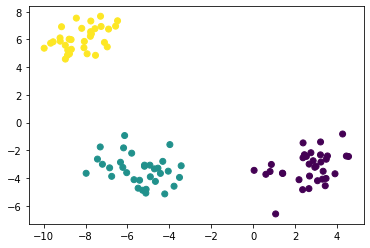

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [4]:
# GMMs

In [5]:
# 1. EM: Initlization and E-step

def _kmeans_init(X, n_component):
    n_samples = X.shape[0]
    kmeans = KMeans(n_clusters=n_components).fit(X)
    labels = kmeans.labels_
    
    weight_matrix = None
    
    for i in range(n_component):
        sub_component = X[labels==i]
        
        pi = sub_component.shape[0]/n_samples
        mean = np.mean(sub_component, axis=0)
        cov = np.cov(sub_component.T)
        
        pdf_value = multivariate_normal.pdf(X, mean, cov)
        weight = pi*pdf_value
        
        if weight_matrix is None:
            weight_matrix = weight
        else:
            weight_matrix = np.column_stack((weight_matrix, weight))
        
    weight_sum = np.sum(weight_matrix, axis=1)[:, np.newaxis]
    weights = weight_matrix/weight_sum
    return weights

def _initialize(X, n_component, method):
    n_samples = X.shape[0]
    if method == 'random':
        weights = np.random.rand(n_samples, n_components)
        w = weights.sum(axis=1)
        weight_sum = weights.sum(axis=1)[:, np.newaxis]
        weights /= weight_sum
    else:
        weights = _kmeans_init(X, n_component)
    return weights

In [6]:
# 2. EM: M-step

def _update_means(X, weights):
    weight_sum = np.sum(weights, axis=0)
    means = X.T.dot(weights)/weight_sum
    return means

# equation(17) A = sum_{i=1}^n w_{ik}(x_i - \mu_k)(x_i - \mu_k).T
# A_{st} = \sum_{i=1}^n w_{ik}x_{is}x_{it} - \sum_{i=1}^n\mu_{ks}x_{it} - \sum_{i=1}^n\mu_{kt}x_{is} + \sum_{i=1}^n\mu_{ks}\mu_{kt})
# 1 <= s, t <= m
# A_{st} = A1_{st} - A2_{st} - A3_{st} + A4_{st}
# A1 = w_k*(X.T)
# A2 = A3.T
# A3 = \mu_k((w_k*(X.T)).dot(H))
# A4 = (\sum_{i=1}^n w_{ik})*(\mu_k.dot(\mu_k.T))
def _update_covs(X, n_components, weights, means):
    n, m = X.shape
    covs = None
    H = np.ones(shape=(n, m))
    
    for k in range(n_components):
        weight = weights[:, k]
        weight_sum = np.sum(weight)
        mean = means[:, k]
        weighted_X_T = weight*(X.T)
        
        a1 = (weighted_X_T).dot(X)
        a3 = mean*(weighted_X_T.dot(H))
        a2 = a3.T
        mean_reshaped = mean.reshape(-1, 1)
        a4 = weight_sum*((mean_reshaped).dot(mean_reshaped.T))
        a = a1 - a2 - a3 + a4
        
        cov = a/weight_sum
        if covs is None:
            covs = cov
        else:
            covs = np.dstack((covs, cov))
    return covs

def _update_pis(weights):
    w_each_component = np.sum(weights, axis=0)
    w_sum = np.sum(w_each_component)
    pis = w_each_component/w_sum
    return pis

def _update_weights(X, n_components, means, covs, pis):
    weighted_pdf_array = None
    for k in range(n_components):
        mean = means[:, k]
        cov = covs[:,:,k]
        pi = pis[k]
        pdf_values = multivariate_normal.pdf(X, mean, cov)
        weighted_pdf_values = pi*pdf_values
        if weighted_pdf_array is None:
            weighted_pdf_array = weighted_pdf_values
        else:
            weighted_pdf_array = np.column_stack((weighted_pdf_array, weighted_pdf_values))
    
    weighted_sum = np.sum(weighted_pdf_array, axis=1)[:, np.newaxis]
    weights = weighted_pdf_array/weighted_sum
    return weights

In [7]:
# 3. GMM with EM

def gmm_fit(X, n_components, init_method, max_iter=100):
    weights = _initialize(X, n_components, init_method)
    iter_left = max_iter
    while iter_left > 0:
        means = _update_means(X, weights)
        covs = _update_covs(X, n_components, weights, means)
        pis = _update_pis(weights)
        weights_next = _update_weights(X, n_components, means, covs, pis)
        
        if np.allclose(weights, weights_next):
            print('converage at step', max_iter-iter_left)
            break
        else:
            weights = weights_next
            iter_left -= 1
    return means, covs, weights_next

In [8]:
# 4. predict labels
def gmm_predict(X, n_components, means, covs, weights):
    pdf_values = None
    for k in range(n_components):
        mean = means[:, k]
        cov = covs[:, :, k]
        pdf_value = multivariate_normal.pdf(X, mean, cov)
        if pdf_values is None:
            pdf_values = pdf_value
        else:
            pdf_values = np.column_stack((pdf_values, pdf_value))
    labels = np.argmax(pdf_values, axis=1)
    return labels

In [9]:
# 5. gmm

def gmm_fit_predict(X, n_components, init_method, max_iter):
    means, covs, weights = gmm_fit(X, n_components, init_method, max_iter)
    labels = gmm_predict(X, n_components, means, covs, weights)
    return labels

In [10]:
n_components = 3
gmm_labels_kmeans = gmm_fit_predict(X, n_components, 'kmeans', max_iter=1000)
gmm_labels_random = gmm_fit_predict(X, n_components, 'random', max_iter=1000)

converage at step 2
converage at step 46


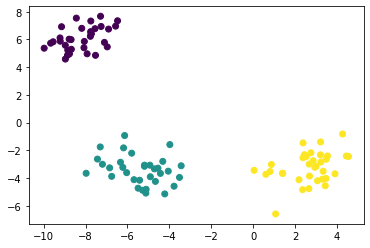

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=gmm_labels_kmeans)

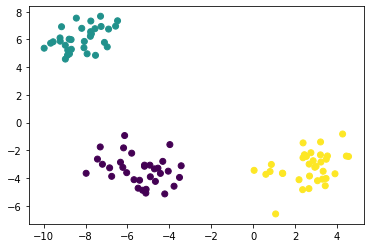

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=gmm_labels_random)

In [13]:
def plot_scatter(ax, X, labels, title):
    ax.scatter(X[:, 0], X[:, 1], c=labels)
    ax.set_title(title)

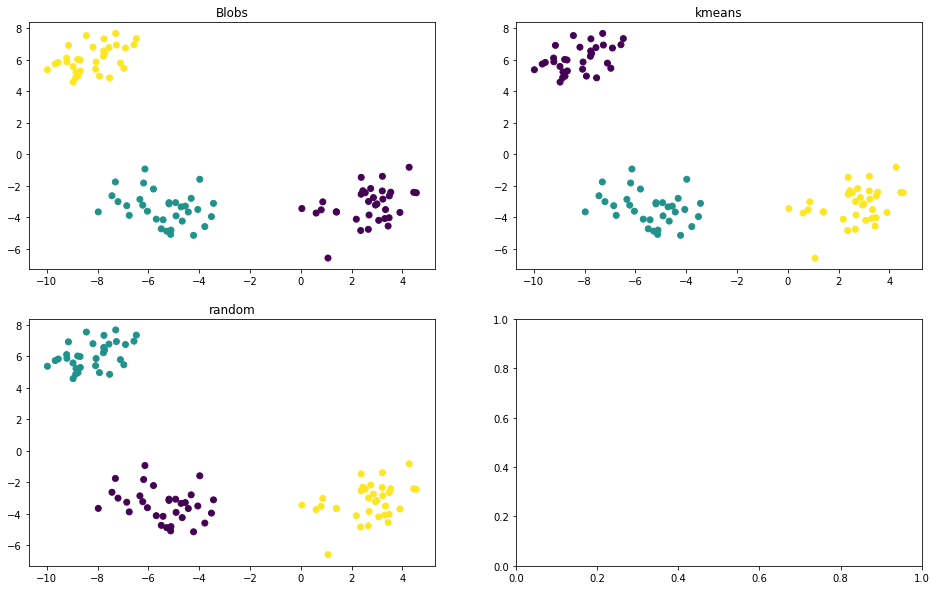

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
plot_scatter(axes[0, 0], X, y, 'Blobs')
plot_scatter(axes[0, 1], X, gmm_labels_kmeans, 'kmeans')
plot_scatter(axes[1, 0], X, gmm_labels_random, 'random')